In [7]:
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import csv
import re

def read_csv_file(file_path):
    # Initialisiere eine leere Liste, um die bereinigten Daten zu speichern
    cleaned_data = []

    # Lese die CSV-Datei
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')  # Annahme: Semikolon als Trennzeichen
        for row in reader:
            # Verbinde die Zeilenelemente mit einem Komma, um das Trennzeichen zu vereinheitlichen
            unified_row = ','.join(row)
            # Ersetze mehrere aufeinander folgende Kommas durch ein einzelnes Komma
            unified_row = re.sub(r',+', ',', unified_row)
            # Teile die vereinheitlichte Zeile nach dem Komma auf
            split_row = unified_row.split(',')
            # Entferne die ersten zwei Parameter
            cleaned_row = split_row[1:]
            # Füge die bereinigte Zeile der Liste hinzu
            cleaned_data.append(cleaned_row)

    return cleaned_data

# Beispiel: Daten aus "input.csv" einlesen

data = pd.read_csv("initial_data.csv")
cleaned_data = read_csv_file("querys_ForcePush.csv")
df_queried = pd.DataFrame(cleaned_data[1:], columns=cleaned_data[0])
def add_data(data, queried_data):
    # add queried data (without cost) to initial data
    print(queried_data.keys())
    queried_data = queried_data[queried_data['costs'] == 1]
    data = pd.concat([data, queried_data.iloc[:, :13]], axis=0)

    # data = data.append(queried_data, ignore_index=True)
    return data

data = add_data(data, df_queried)
data = data.reset_index().astype('Float32')


# Teile die Daten in Features (X) und Ziel (y) auf
x = data[["Engine speed", "Engine load", "Railpressure", "Air supply", "Crank angle", "Intake pressure", "Back pressure", "Intake temperature"]].values
y = data[["NOx", "PM 1", "CO2", "PM 2", "Pressure cylinder"]].values

# Teile die Daten in Trainings- und Testsets auf
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Standardisiere die Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Trainiere ein Support Vector Regressor (SVR)-Modell
print(X_train_scaled.shape)
svr = SVR(kernel="linear", C=1, epsilon=0.1)
multi_output_svr = MultiOutputRegressor(svr)
multi_output_svr.fit(X_train, y_train)

# Mache Vorhersagen auf dem Testset
y_pred = multi_output_svr.predict(X_test_scaled)





Index(['Engine speed', 'Engine load', 'Railpressure', 'Air supply',
       'Crank angle', 'Intake pressure', 'Back pressure', 'Intake temperature',
       'NOx', 'PM 1', 'CO2', 'PM 2', 'Pressure cylinder', 'costs'],
      dtype='object')
(141, 8)


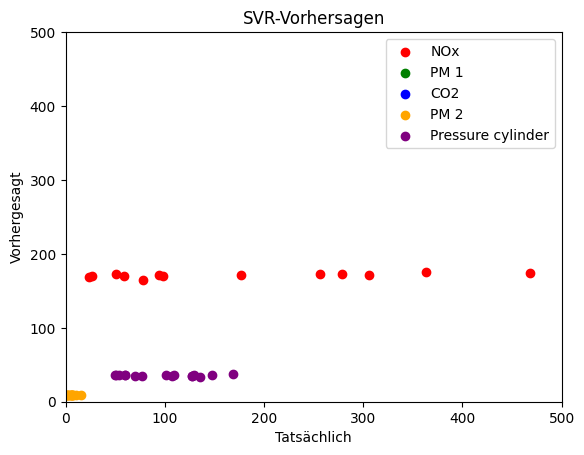

In [8]:

# Zeige die SVR-Vorhersagen in einem Diagramm
plt.xlim(0,500)
plt.ylim(0,500)
plt.scatter(y_test[:, 0], y_pred[:, 0], color="red", label="NOx")
plt.scatter(y_test[:, 1], y_pred[:, 1], color="green", label="PM 1")
plt.scatter(y_test[:, 2], y_pred[:, 2], color="blue", label="CO2")
plt.scatter(y_test[:, 3], y_pred[:, 3], color="orange", label="PM 2")
plt.scatter(y_test[:, 4], y_pred[:, 4], color="purple", label="Pressure cylinder")
plt.xlabel("Tatsächlich")
plt.ylabel("Vorhergesagt")
plt.title("SVR-Vorhersagen")
plt.legend()
plt.show()

In [9]:
# Berechne die Abweichung (Residuen) für jedes Ausgabeattribut
residuen = y_test - y_pred

# Berechne den durchschnittlichen absoluten Fehler für jedes Ausgabeattribut
mae = np.mean(np.abs(residuen), axis=0)
for i in range(0,5):
    mse = mean_squared_error(y_test[:,i], y_pred[:,i])
    #print(str(i) + ". mse: " + str(mse))
    varianz = np.var(y_test[:,i])
    print("normalisiert \t" + str(mse/varianz))

# Gib die durchschnittlichen absoluten Fehler für jedes Ausgabeattribut aus
for i in range(y_test.shape[1]):
    print(f"Durchschnittlicher absoluter Fehler für Ausgabespalte {i+1}: {mae[i]}")

normalisiert 	1.1459241797026263
normalisiert 	38.09332999771429
normalisiert 	8.00726061935612
normalisiert 	1.0665535672882618
normalisiert 	3.8278994496029504
Durchschnittlicher absoluter Fehler für Ausgabespalte 1: 191.85610114898688
Durchschnittlicher absoluter Fehler für Ausgabespalte 2: 9.938758215931207
Durchschnittlicher absoluter Fehler für Ausgabespalte 3: 123.27575123729875
Durchschnittlicher absoluter Fehler für Ausgabespalte 4: 4200.246082084066
Durchschnittlicher absoluter Fehler für Ausgabespalte 5: 62.91342726622967


In [10]:
yo = pd.DataFrame(y_pred)
for i in range(0,5):
    print(str(y_pred[:,i].min()) + " - " +str(y_pred[:,i].max()))
print("-----")
for i in range(0,5):
    print(str(y[:,i].min()) + " - " +str(y[:,i].max()))


163.07445151005834 - 186.14157010327483
-8.167097901690104 - -7.638930544889481
-61.60383817800823 - -57.13330143468113
8.622143099238842 - 9.468785531267445
33.530846398186505 - 37.408337791092045
-----
15.851380348205566 - 1347.027099609375
0.1314121037721634 - 37.41849899291992
2.8916282653808594 - 163.0805206298828
0.0009764843271113932 - 67145.0
43.95541000366211 - 168.84547424316406


In [11]:
for i in range(0,5):
    #mape = sklearn.mean(np.abs((y_test[:,i] - y_pred[:,i])/y_test[:,i])) * 100
    mape= mean_absolute_percentage_error(y_test[:,i], y_pred[:,i]) * 100
    print(mape)


143.79566362009726
888.2798810803549
315.1064768038559
964.7807523240692
57.59983937628845


In [12]:
data = pd.read_csv("initial_data.csv")
submission_data = pd.read_csv("submission.csv")

submission_keys = submission_data.keys()
data_keys = ['Engine speed', 'Engine load', 'Railpressure', 'Air supply', 'Crank angle', 'Intake pressure', 'Back pressure', 'Intake temperature']

for sub_key, data_key in zip(submission_keys, data_keys):
    submission_data = submission_data.rename(columns={sub_key:data_key})


print(submission_data.shape)


submission_results = multi_output_svr.predict(submission_data.values)

submission_results = np.transpose(submission_results)
submission_mean = []
submission_std = []
for feature in submission_results:
    submission_mean.append(feature.mean())
    submission_std.append(feature.std())

data_mean = []
data_std = []
y_t = np.transpose(y)
for feature in y_t:
    data_mean.append(feature.mean())
    data_std.append(feature.std())

print(submission_mean)
print(submission_std)
print(data_mean)
print(data_std)

q_mean = np.divide(data_mean, submission_mean)
q_std = np.divide(data_std, submission_std)

print("\nQuotienten von mean und std:\n")
print(q_mean)
print(q_std)




(57892, 8)
[226.82510875088195, 0.8126433817923715, 51.93750863543324, 2.6040563853818863, 110.11609555059434]
[137.27770721415462, 4.000555905096562, 33.76661700244551, 3.5646475868605725, 25.84024355075858]
[224.5001825405534, 2.8244946435758265, 59.6247462983344, 662.9760147131639, 94.68207732279589]
[215.20052498797537, 4.722424094561472, 39.60092439134057, 5668.017382597124, 31.8604239433137]

Quotienten von mean und std:

[  0.98975014   3.47568775   1.14800936 254.59357118   0.85983867]
[1.56762907e+00 1.18044197e+00 1.17278330e+00 1.59006388e+03
 1.23297692e+00]
